# CSDMC 2010 Malware Detection Using Hierarchical Attention Networks

### Problem description
Dynamic process analysis aims to identify a malicious process *while it is running* on a host system. The main challenge is to detect the questionable behavior as soon as possible by observing the actions performed by the running process.

We will use the [CSDMC 2010 Malicious Software](http://csmining.org/index.php/malicious-software-datasets-.html) dataset to simulate dynamic process analysis using API calls. We will also classify the full process trace to identify malicious intent.

Note that the CSDMC 2010 dataset contains only the API calls without any arguments. The solution in this notebook is more generalized, supporting any number of fields per API call. There is no need for normalization in the CSDMC dataset case, and MAX_FIELDS should be set to 1.

### Proposed solution
The solution demonstrated in this notebook is inspired by the domain of natural language processing, and document classification in particular. Determining the sentiment and/or topic expressed in a text document requires a deeper understanding of the words, sentences, language structure, writing style, and syntactic and semantic structure of the document.

Yang, Zichao et al proposed a [hierachical attention network for document classification](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/06/Hierarchical-Attention-Networks-for-Document-Classification.pdf)), presented at [NAACL 2016](http://aclweb.org/anthology/N/N16/). The solution leverages the hierarchical structure of a document, from words to sentences to documents, mirrored in a multi-layer [recurrent neural network](https://en.wikipedia.org/wiki/Recurrent_neural_network) with special *attention* layers applied at the word and the sentence levels. The architecture of the Hierarchical Attention Network (HAN) is shown in the figure below. The overall process is nicely  described in details in this [blog](https://explosion.ai/blog/deep-learning-formula-nlp).

![Hierarchical Attention Network](HierachicalAttention.png)

We propose a dynamic process analysis solution that leverages multi-layers of *memory and understanding* of the sequence of observed process actions based on hiearchical attention networks. If we think of the sequence of process actions as analogous to sequence of words in text, and groups of actions as sentences, classifying patterns of process behavior could then be viewed as classifying documents.

![HAN for process analysis](HAN-proc-analysis1.png)

### Some implementation details
1. Data format: Process traces are represented as tab-separated tuples of (action, target, sub-target, status, ..). 
2. Pre-processing: Fields other than process action are normalized to limit the target/sub-target variations. For e.g., registry keys, files/folders are represented in a shortened form to collapse many values to a representative normalized form.
3. Any number of fields can be included in model training, as defined in the parameter MAX_FIELDS.
4. Each field in a process action tuple is equivalent to a *word*.
5. Number of words per *sentence* and number of sentences in a *document* are configurable.
6. Word embeddings can be initialized using pre-trained vectors, or left uninitialized. Defined by parameter USE_WORD2VEC.
7. Other configurable options define various network dimensions, learning hyper-parameters, data sampling options, etc.
8. Deep learning framework: Keras with a CNTK backend, with GPU support.

The HAN code in this notebook is based on the LSTM HAN implementation found in this [GitHub notebook](https://github.com/anargyri/lstm_han/blob/master/hatt_archive_cntk.ipynb) by Andreas Argyriou. The base notebook is based on [Richard Liao's implementation of hierarchical attention networks](https://github.com/richliao/textClassifier/blob/master/textClassifierHATT.py) and a related [Google group discussion](https://groups.google.com/forum/#!topic/keras-users/IWK9opMFavQ). The notebook also includes code from [Keras documentation](https://keras.io/) and [blog](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) as well as this [word2vec tutorial](http://adventuresinmachinelearning.com/gensim-word2vec-tutorial/).

In [1]:
%matplotlib inline
%pylab inline

import numpy as np
import os 
import time
import re
from datetime import datetime
import matplotlib.pyplot as plt

os.environ['KERAS_BACKEND'] = 'cntk'
from cntk.device import try_set_default_device, gpu, cpu
from cntk.cntk_py import set_fixed_random_seed
from cntk.cntk_py import set_computation_network_trace_level, set_checked_mode
from cntk.cntk_py import force_deterministic_algorithms, disable_forward_values_sharing
from cntk.debugging import debug_model

# Set default device - negative for cpu (optional)
gpu_device = 1
if gpu_device >= 0:
    try_set_default_device(gpu(gpu_device))
else:
    try_set_default_device(cpu())

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD, Adam, Adagrad

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model, load_model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, optimizers
from keras.callbacks import History, CSVLogger, ModelCheckpoint

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

Populating the interactive namespace from numpy and matplotlib


Using CNTK backend


### Read clean and ransomware Action -> Target tuples from files

In [2]:
class1_srcfile = './data/csdmc_clean.txt'
class2_srcfile = './data/csdmc_malware.txt'

class1_srctext = open(class1_srcfile).readlines()
class2_srctext = open(class2_srcfile).readlines()

print('Read %d class1 tuples' % len(class1_srctext))
print('Read %d class2 tuples' % len(class2_srctext))

Read 1329976 class1 tuples
Read 1317776 class2 tuples


In [3]:
print(class1_srctext[0:5])

['RegOpenKeyExW\n', 'LoadLibraryA\n', 'GetProcAddress\n', 'GetProcAddress\n', 'GetProcAddress\n']


In [4]:
print(class2_srctext[0:5])

['LoadLibraryW\n', 'HeapAlloc\n', 'HeapAlloc\n', 'HeapFree\n', 'HeapAlloc\n']


### Set configurable parameters

1. Set the dimensions of the input and the embedding. Because of the hierarchical nature of the network, the input has to be a 3-dimensional tensor of fixed size (sample_size x n_sentences x n_words). 
   <br>MAX_SENT_LEN : the number of words in each sentence (a word in any token appearing in a process action tuple). 
   <br>MAX_SENTS : the number of sentences in each document.
   <br>MAX_NB_WORDS : the size of the word encoding (number of most frequent words to keep in the vocabulary)
   <br>**Note:** MAX_NB_WORDS is automatically adjusted to match the action tuples vocabulary size
   <br>EMBEDDING_DIM : the dimensionality of the word embedding
   <br>GRU_UNITS: the dimensionality of the GRU layers
   <br>CONTEXT_DIM: the dimensionality of attention layers
<br><br>   
2. Set the runtime parameters:
   <br>MAX_FIELDS: number of fields to include form each process action tuple
   <br>BY_PROCESS: if True, indicates stratified sampling by process, i.e., actions in one process are either training or test
   <br>if false, sampling is done at a seqnece (sentence) level
   <br>use_ratio, balance_ratio, over_sample: control how sampling is done to oprionally balance class distribution
<br><br> 
3. Set the learning hyper-parameters:
   <br>LEARN_RATE: learning rate
   <br>REG_PARAM:  regularization parameter
   <br>BATCH_SIZE: number of sequences to include per training batch
   <br>NUM_EPOCHS: number of training epochs

In [5]:
# Sequence/sentence dimensions
MAX_FIELDS      = 1                      # which tuple fields to include from dataset
MAX_SENT_LENGTH = 20 * MAX_FIELDS        # multiple of MAX_FIELDS tuples
MAX_SENTS       = 5
MAX_NB_WORDS    = 100000    # much higher than we expect in the vocabulary, will be adjusted based on actual vocab size
MIN_FREQ        = 0         # limit vocabulary size by token frequency
SENT_SEPARATOR  = '<eos>'
BY_PROCESS      = True      # sample and split by process or by sequence
train_split     = 0.9       # training/validation split
use_ratio       = 1.0       # limit training size if needed
balance_ratio   = -1        # ratio to balance classes in multiples of the under-represented class, use -1 for no balancing
over_sample     = False     # balance by over sampling the minority class, otherwise under sample the majority class

# Model definition parameters
USE_WORD2VEC  = True       # initialize embeddings with pre-trained word2vec weights
ORDER_DOCS    = False       # order sequences by length prior to training - not needed since lengths are mostly equal
EMBEDDING_DIM = 50
GRU_UNITS     = 100
CONTEXT_DIM   = 100

# Learning hyper-parameters
REG_PARAM     = 1e-13
LEARN_RATE    = 0.01
BATCH_SIZE    = 32
NUM_EPOCHS    = 20

### Function to process input action tuples to construct sentences, sequences and labels

In [6]:
def get_sequences(source_text, label, proc_start=0):
    global sentences, labels, texts, processes
    token_count = 0
    sent_count  = 0
    seq_count   = 0
    total_count = 0
    total_sent  = 0
    total_seq   = 0
    total_proc  = 0
    text  = ''
    sents = []
    
    for line in source_text:
        line   = line.strip().lower()
        line = re.sub('\s+', ' ', line).strip()
        tokens = line.split()[0:MAX_FIELDS]
        text  += ' '.join(tokens) + ' '
        #tokens = line.split()
        #text  += line + ' '
        token_count += len(tokens)
        total_count += len(tokens)
    
        if token_count >= MAX_SENT_LENGTH or tokens[0] == SENT_SEPARATOR:
            sents.append(text.strip())
            sent_count += 1
            total_sent += 1
            token_count = 0
            text = ''
        
        if sent_count == MAX_SENTS or tokens[0] == SENT_SEPARATOR:
            texts.append(' '.join(sents))
            sentences.append(sents)
            seq_count += 1
            total_seq += 1
            sents      = []
            sent_count = 0
            if tokens[0] == SENT_SEPARATOR:
                proc_end   = proc_start + seq_count
                processes.append([proc_start, proc_end, seq_count, label])
                proc_start = proc_end
                seq_count = 0
                total_proc += 1

    labels = np.concatenate((labels, np.repeat(label, total_seq)), axis=0)
    print('Processed sequences for label = %d' % label)
    print('Processes = %d' % total_proc)
    print('Sequences = %d' % total_seq)
    print('Sentences = %d' % total_sent)
    print('Tokens    = %d' % total_count)
    
    return proc_end

#### Transform input data into sequences and sentences, with labels

In [7]:
# Extract sequences and sentences from clean and ransom source text
sentences = []
labels    = np.empty(0)
texts     = []
processes = []

next_proc_start = 0
next_proc_start = get_sequences(class1_srctext, 0, proc_start = next_proc_start)
next_proc_start = get_sequences(class2_srctext, 1, proc_start = next_proc_start)

print('Total # of processes       = %d' % len(processes))
print('Total # of text sequences  = %d' % len(texts))
print('Total # of sentence groups = %d' % len(sentences))
print('Total # of labels          = %d' % len(labels))

Processed sequences for label = 0
Processes = 68
Sequences = 13336
Sentences = 66534
Tokens    = 1329976
Processed sequences for label = 1
Processes = 320
Sequences = 13329
Sentences = 66041
Tokens    = 1317776
Total # of processes       = 388
Total # of text sequences  = 26665
Total # of sentence groups = 26665
Total # of labels          = 26665


In [8]:
print(processes[0:10])
print(processes[-10:])

[[0, 1, 1, 0], [1, 131, 130, 0], [131, 1879, 1748, 0], [1879, 2040, 161, 0], [2040, 2212, 172, 0], [2212, 2214, 2, 0], [2214, 2222, 8, 0], [2222, 2356, 134, 0], [2356, 2365, 9, 0], [2365, 2366, 1, 0]]
[[26350, 26372, 22, 1], [26372, 26477, 105, 1], [26477, 26539, 62, 1], [26539, 26562, 23, 1], [26562, 26586, 24, 1], [26586, 26619, 33, 1], [26619, 26629, 10, 1], [26629, 26643, 14, 1], [26643, 26664, 21, 1], [26664, 26665, 1, 1]]


In [9]:
print(texts[0])
#print(texts[10])

regopenkeyexw loadlibrarya getprocaddress getprocaddress getprocaddress getprocaddress getprocaddress loadlibrarya getprocaddress getprocaddress loadlibrarya getprocaddress regopenkeyexa freelibrary getprocaddress getprocaddress getprocaddress getmodulehandlea getprocaddress getmodulehandlea getprocaddress regcreatekeyexa <eos>


#### Extract the process action vocabulary using a Keras tokenizer

In [10]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

# limit vocabulary size by token frequence
vocab = [k for k in tokenizer.word_counts.keys() if tokenizer.word_counts[k] > MIN_FREQ]
print('Vocabulary size with frequency > %d = %d' % (MIN_FREQ, len(vocab)))

if len(vocab) < MAX_NB_WORDS:
    MAX_NB_WORDS = len(vocab) + 1      # index 0 is not used

print('Max number of words = %d' % MAX_NB_WORDS)

Total 316 unique tokens.
Vocabulary size with frequency > 0 = 316
Max number of words = 317


In [11]:
#print(tokenizer.word_counts)
#print(tokenizer.texts_to_matrix(sentences[0][0], mode='binary'))

#### Transform the data into the 3D format required for the tensors

In [12]:
data = np.zeros((len(sentences), MAX_SENTS, MAX_SENT_LENGTH), dtype='float32')
doc_lst = []

# keep the MAX_NB_WORDS most frequent words and replace the rest with 'UNK'
# truncate to the first MAX_SENTS sentences per doc and MAX_SENT_LENGTH words per sentence

for i, sentence in enumerate(sentences):
    for j, sent in enumerate(sentence):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            words_in_sent = []
            for _, word in enumerate(wordTokens):
                if k < MAX_SENT_LENGTH: 
                    if (word in tokenizer.word_index) and (tokenizer.word_index[word] < MAX_NB_WORDS):
                        data[i, j, k] = tokenizer.word_index[word]
                        words_in_sent.append(word)
                    else:
                        data[i, j, k] = MAX_NB_WORDS
                        words_in_sent.append('UNK')
                    k = k + 1
            doc_lst.append(words_in_sent)

In [13]:
print(data.shape, len(doc_lst))
#print(data.shape)
print(labels.shape)
print(len(sentences[0]))
print(len(texts[0].split()))

(26665, 5, 20) 132575
(26665,)
2
23


#### Convert the class labels to one-hot categorical representation

In [14]:
y_all = to_categorical(np.asarray(labels)).astype('int32')
x_all = data

print('Shape of data tensor:', x_all.shape)
print('Shape of label tensor:', y_all.shape)

Shape of data tensor: (26665, 5, 20)
Shape of label tensor: (26665, 2)


In [15]:
n_classes = y_all.shape[1]

#### Function to extract word embedding vectors from a pre-trained word2vec model (optional)

In [16]:
# train word2vec on the sentences to initialize the word embedding 
def get_embedding_matrix(sents, word_index, embedding_dim=100, max_num_words=1000):
    import gensim, logging

    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    # use skip-gram
    word2vec_model = gensim.models.Word2Vec(sents, min_count=1, size=embedding_dim, sg=1, workers=os.cpu_count())
    
    # Create the initial embedding matrix from the output of word2vec
    embeddings_index = {}

    for word in word2vec_model.wv.vocab:
        coefs = np.asarray(word2vec_model.wv[word], dtype='float32')
        embeddings_index[word] = coefs

    # Empty embeddings for padding UNK terms
    embeddings_index['UNK'] = np.zeros(embedding_dim, dtype='float32')
    
    print('Total %s word vectors.' % len(embeddings_index))
    
    # Initial embedding
    embedding_matrix = np.zeros((max_num_words + 1, embedding_dim))

    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None and i < max_num_words:
            embedding_matrix[i] = embedding_vector
        elif i == max_num_words:
            # index MAX_NB_WORDS in data corresponds to 'UNK'
            embedding_matrix[i] = embeddings_index['UNK']
            
    return embedding_matrix

#### Function to define the word embeddings layer, with or without word2vec weights

In [17]:
# Define embedding layer structure and optionally initialize weights
def get_embedding_layer(embedding_dim=100, embedding_matrix=None, max_num_words=1000, max_sent_length=40, reg_param=1e-13):
    l2_reg = regularizers.l2(reg_param)

    if embedding_matrix is not None:
        # Embedding layer initialized with word2vec coefficients
        embedding_layer = Embedding(max_num_words + 1,
                            embedding_dim,
                            input_length=max_sent_length,
                            trainable=True,
                            mask_zero=True,
                            embeddings_regularizer=l2_reg,
                            weights=[embedding_matrix])
    else:
        # Embedding layer with no pre-trained weiths
        embedding_layer = Embedding(max_num_words + 1,
                            embedding_dim,
                            input_length=max_sent_length,
                            trainable=True,
                            mask_zero=True,
                            embeddings_regularizer=l2_reg)

    return embedding_layer

#### Definition of a custom layer implementing the attention mechanism

In [18]:
class AttLayer(Layer):
    def __init__(self, regularizer=None, context_dim=100, **kwargs):
        self.regularizer = regularizer
        self.context_dim = context_dim
        self.supports_masking = True
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3        
        self.W = self.add_weight(name='W', shape=(input_shape[-1], self.context_dim), initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)
        self.b = self.add_weight(name='b', shape=(self.context_dim,), initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)
        self.u = self.add_weight(name='u', shape=(self.context_dim,), initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)        
        super(AttLayer, self).build(input_shape)  # be sure you call this somewhere!

    def call(self, x, mask=None):
        eij = K.dot(K.tanh(K.dot(x, self.W) + self.b), K.expand_dims(self.u))
        ai = K.exp(eij)
        alphas = ai / K.sum(ai, axis=1)
        if mask is not None:
            # use only the inputs specified by the mask
            alphas *= K.expand_dims(mask)
        weighted_input = K.dot(K.transpose(x), alphas)
        return K.reshape(weighted_input, (weighted_input.shape[0],))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])
    
    def get_config(self):
        config = {}
        base_config = super(AttLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask):
        return None

#### Function to create the network model structure
GRU_UNITS is the dimensionality of each GRU output (the number of GRU units). GRU_IMPL = 2 selects a matricized RNN implementation which is more appropriate for training on a GPU. 

There are two levels of models in the definition. The sentence model `sentEncoder` is shared across all sentences in the input document.   

In [19]:
def create_model(n_classes, reg_param=1e-13, embedding_dim=100, embedding_matrix=None, gru_units=100, context_dim=100, max_sents=5, max_sent_length=40, max_num_words=1000):
    GPU_IMPL = 2 
    l2_reg = regularizers.l2(reg_param)

    sentence_input = Input(shape=(max_sent_length,), dtype='float32')
    embedding_layer = get_embedding_layer(embedding_dim=embedding_dim, embedding_matrix=embedding_matrix,
                                          max_num_words=max_num_words, max_sent_length=max_sent_length, 
                                          reg_param=reg_param)
    embedded_sequences = embedding_layer(sentence_input)
    l_lstm = Bidirectional(GRU(gru_units, return_sequences=True, kernel_regularizer=l2_reg, 
                           implementation=GPU_IMPL))(embedded_sequences)
    l_att = AttLayer(regularizer=l2_reg, context_dim=context_dim)(l_lstm)            
    sentEncoder = Model(sentence_input, l_att)

    doc_input = Input(shape=(max_sents, max_sent_length), dtype='float32')
    doc_encoder = TimeDistributed(sentEncoder)(doc_input)
    l_lstm_sent = Bidirectional(GRU(gru_units, return_sequences=True, kernel_regularizer=l2_reg, 
                                implementation=GPU_IMPL))(doc_encoder)
    l_att_sent = AttLayer(regularizer=l2_reg, context_dim=context_dim)(l_lstm_sent) 
    preds = Dense(n_classes, activation='softmax', kernel_regularizer=l2_reg)(l_att_sent)
    model = Model(doc_input, preds)
    
    return model

#### Function to train the HAN model (uses 10% of train data for validation)

In [20]:
def train(train_x, train_y, model, model_path, batch_size=32, num_epochs=10, reg_param=1e-13, show_hist=True):
    set_fixed_random_seed(1)                           # fix a random seed for CNTK components
    #set_computation_network_trace_level(1000)         # debugging mode
    disable_forward_values_sharing()                   # to debug Titan X NaN loss issue

    fname = './csdmc_ransom_detection_f%d' % (MAX_FIELDS)

    if USE_WORD2VEC:
        filepath = '%s/checkpoint-{epoch:02d}-f%d-dim=%d-w2v-strat-lr=%.2f.hdf5' % (model_path, MAX_FIELDS, EMBEDDING_DIM, LEARN_RATE)
    else:
        filepath = '%s/checkpoint-{epoch:02d}-f%d-dim=%d-now2v-strat-lr=%.2f.hdf5' % (model_path, MAX_FIELDS, EMBEDDING_DIM, LEARN_RATE)

    sgd_optimizer     = optimizers.SGD(lr=LEARN_RATE, nesterov=True)
    #sgd_optimizer     = optimizers.SGD(lr=LEARN_RATE, decay=1e-6, momentum=0.9, nesterov=True)
    adam_optimizer    = optimizers.Adam(lr=LEARN_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    adagrad_optimizer = optimizers.Adagrad(lr=LEARN_RATE, epsilon=1e-08, decay=0.0)
    
    model.compile(loss='categorical_crossentropy',
              optimizer=sgd_optimizer,
              metrics=['acc'])
    model.summary()

    train_x = train_x.astype(np.float32)
    #train_y = train_y.astype(np.float32)
    
    # set callback functions
    history = History()
    csv_logger = CSVLogger('./{0}_{1}.log'.format(fname, reg_param), separator=',', append=True)
    checkpoint = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=False)
 
    print(str(datetime.now()))
    t1 = time.time()
    # for final training, train without validation split
    # hist_results = model.fit(train_x[ind,:,:], train_y[ind,:], epochs=num_epochs, batch_size=batch_size, shuffle=False, 
    #          callbacks=[checkpoint, history, csv_logger], verbose=2)
    hist_results = model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, shuffle=False, 
          callbacks=[checkpoint, history, csv_logger], verbose=2)

    t2 = time.time()
    print(str(datetime.now()))
    print('Training time = %.3f' % (t2 - t1))
    
    if show_hist:
        show_history(hist_results)
    
    return model, hist_results

#### Function to train the HAN model and validate using a separate validation set

In [21]:
def train_validate(train_x, train_y, test_x, test_y, model, model_path, batch_size=32, num_epochs=10, reg_param=1e-13, show_hist=True):
    set_fixed_random_seed(1)                           # fix a random seed for CNTK components
    #set_computation_network_trace_level(1000)         # debugging mode
    disable_forward_values_sharing()                   # to debug Titan X NaN loss issue

    fname = './csdmc_ransom_detection_f%d' % (MAX_FIELDS)

    if USE_WORD2VEC:
        filepath = '%s/checkpoint-{epoch:02d}-f%d-dim=%d-w2v-strat-lr=%.2f.hdf5' % (model_path, MAX_FIELDS, EMBEDDING_DIM, LEARN_RATE)
    else:
        filepath = '%s/checkpoint-{epoch:02d}-f%d-dim=%d-now2v-strat-lr=%.2f.hdf5' % (model_path, MAX_FIELDS, EMBEDDING_DIM, LEARN_RATE)

    sgd_optimizer     = optimizers.SGD(lr=LEARN_RATE, nesterov=True)
    #sgd_optimizer     = optimizers.SGD(lr=LEARN_RATE, decay=1e-6, momentum=0.9, nesterov=True)
    adam_optimizer    = optimizers.Adam(lr=LEARN_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    adagrad_optimizer = optimizers.Adagrad(lr=LEARN_RATE, epsilon=1e-08, decay=0.0)
    
    model.compile(loss='categorical_crossentropy',
              optimizer=sgd_optimizer,
              metrics=['acc'])
    model.summary()

    train_x = train_x.astype(np.float32)
    #train_y = train_y.astype(np.float32)
    
    # set callback functions
    history = History()
    csv_logger = CSVLogger('./{0}_{1}.log'.format(fname, reg_param), separator=',', append=True)
    checkpoint = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=False)
 
    print(str(datetime.now()))
    t1 = time.time()
    hist_results = model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size, validation_data=(test_x, test_y), shuffle=False, 
          callbacks=[checkpoint, history, csv_logger], verbose=2)

    t2 = time.time()
    print(str(datetime.now()))
    print('Training time = %.3f' % (t2 - t1))
    
    if show_hist:
        show_history(hist_results)
    
    return model, hist_results

#### Function to evaluate a trained HAN model using a test set and save prediction results

In [22]:
def evaluate(test_x, test_y, model, save=False, outfile=None):
    test_x = test_x.astype(np.float32)
    #test_y = test_y.astype(np.float32)

    print(str(datetime.now()))
    t1    = time.time()
    preds = model.predict(test_x)
    t2    = time.time()
    print(str(datetime.now()))
    tdiff = t2 - t1
    print('Evaluation time for %d sequences = %.3f secs --> %.6f sec/sequence\n' % 
                                (len(preds), tdiff, tdiff/len(preds)))

    #print(preds.shape, test_y.shape)
    y_true = np.zeros(test_y.shape[0])
    y_true[y_test[:,1] == 1] = 1
    y_pred = preds.argmax(axis=1)
    print("Accuracy = {0} \t AUC = {1}".format(accuracy_score(y_true, y_pred),
                                           roc_auc_score(y_true, y_pred)))
    print('Confusion matrix:')
    print(confusion_matrix(y_true, y_pred))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plot(fpr, tpr)
    xlabel('FPR')
    ylabel('TPR')

    # Save prediction results for offline analysis
    if save and outfile is not None:
        ff = open(ofname, 'w')
        pid = 0
        sid = 0
        if BY_PROCESS:
            ff.write('test_pid\tproc_sid\tseq_state\ty_true\ty_pred\tprob[0]\tprob[1]\tmatch?\n')
            for i in range(len(y_true)):
                match = (y_true[i] == y_pred[i])
                if text_test[i].endswith('<eos>'):
                    seq = '<eos>'
                else:
                    seq = '<inp>'
                ff.write('%d\t%d\t%s\t%d\t%d\t%10.8f\t%10.8f\t%d\n' % (pid, sid, seq, y_true[i], y_pred[i], preds[i, 0], preds[i, 1], match))
                if text_test[i].endswith('<eos>'):
                    pid += 1
                    sid = 0
                else:
                    sid += 1
        else:
            ff.write('test_sid\tseq_state\ty_true\ty_pred\tprob[0]\tprob[1]\tmatch?\n')
            for i in range(len(y_true)):
                match = (y_true[i] == y_pred[i])
                if text_test[i].endswith('<eos>'):
                    seq = '<eos>'
                else:
                    seq = '<inp>'
                ff.write('%d\t%s\t%d\t%d\t%10.8f\t%10.8f\t%d\n' % (sid, seq, y_true[i], y_pred[i], preds[i, 0], preds[i, 1], match))
                sid += 1 
        ff.close()
        print('Results saved in %s' % outfile)
    return

#### Function to report training and validation progress during model training

In [23]:
def show_history(history):
    # list all data in history
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
    return

### Begin model training process
If USE_WORD2VEC is Ture, train word2vec on all documents in order to initialize the word embedding. Do not ignore rare words (min_count=1). Use skip-gram as the training algorithm (sg=1).<br><br>
**Note:** Using a pre-trained word2vec model is not required if training data is large enough. Experiments with and without pre-training word2vec model produces similar results using the hackathon training data and a few training epochs. The word embeddings are learned in the first 1-2 training epochs.

In [24]:
# Set random seed
np.random.seed(seed=12345)

if USE_WORD2VEC:
    embedding_matrix = get_embedding_matrix(doc_lst, word_index, embedding_dim=EMBEDDING_DIM, max_num_words=MAX_NB_WORDS)
else:
    embedding_matrix = None

c:\anaconda3\envs\python35\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
2018-01-30 11:04:38,767 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2018-01-30 11:04:38,768 : INFO : collecting all words and their counts
2018-01-30 11:04:38,770 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-01-30 11:04:38,805 : INFO : PROGRESS: at sentence #10000, processed 199973 words, keeping 74 word types
2018-01-30 11:04:38,837 : INFO : PROGRESS: at sentence #20000, processed 399717 words, keeping 153 word types
2018-01-30 11:04:38,871 : INFO : PROGRESS: at sentence #30000, processed 599659 words, keeping 162 word types
2018-01-30 11:04:38,906 : INFO : PROGRESS: at sentence #40000, processed 799618 words, keeping 164 word types
2018-01-30 11:04:38,942 : INFO : PROGRESS: at sentence #50000, processed 999

Total 310 word vectors.


**Prepare train/test data split**

Extract a balanced subsample (optional) and split into training and test sets.

In [25]:
if BY_PROCESS:
    num_samples = len(processes)
    train_size  = np.int(num_samples * use_ratio * train_split)
    test_size   = np.int(num_samples * use_ratio) - train_size
    random_idx  = np.random.permutation(num_samples)
    ptrain_idx, ptest_idx = random_idx[:train_size], random_idx[-test_size:]
    p_train, p_test = [processes[i] for i in ptrain_idx], [processes[i] for i in ptest_idx]

    train_idx, test_idx = [], []
    for i, proc in enumerate(p_train):
        train_idx.extend(range(proc[0], proc[1]))
        np.random.shuffle(train_idx)
    for i, proc in enumerate(p_test):
        test_idx.extend(range(proc[0], proc[1]))
        #np.random.shuffle(test_idx)
else:
    num_samples = data.shape[0]
    train_size  = np.int(num_samples * use_ratio * train_split)
    test_size   = np.int(num_samples * use_ratio) - train_size
    random_idx  = np.random.permutation(num_samples)
    train_idx, test_idx = random_idx[:train_size], random_idx[-test_size:]

# Balance label distribution if balance_ratio > 0.0
if balance_ratio > 0.0:
    class_distrib = np.unique(y_all[train_idx,1], return_counts=True)
    print('Original training class distribution = ', class_distrib)
    min_rep_class = class_distrib[0][np.argsort(class_distrib[1])[0]]
    max_rep_class = class_distrib[0][np.argsort(class_distrib[1])[-1]]
    train_idx     = np.asarray(train_idx)
    idx_min_class = train_idx[y_all[train_idx,1] == min_rep_class]
    idx_max_class = train_idx[y_all[train_idx,1] == max_rep_class]
    if over_sample:
        #min_rep_incl  = int(class_distrib[1][max_rep_class] / balance_ratio)
        new_idx_min_class = np.zeros(0, dtype= np.int)
        for i in range(int(balance_ratio)):
            new_idx_min_class = np.concatenate((new_idx_min_class, idx_min_class), axis=0)      # repeat min_class samples to min_rep_incl
        idx_min_class = new_idx_min_class
    else:
        max_rep_incl  = int(class_distrib[1][min_rep_class] * balance_ratio)
        idx_max_class = idx_max_class[:max_rep_incl]                                # limit max_class samples to max_rep_incl

    train_idx     = np.concatenate((idx_min_class, idx_max_class), axis=0)      # merge positive and negative samples
    np.random.shuffle(train_idx)                                                # reshuffle train indices
    print('Final training class distribution    = ', np.unique(y_all[train_idx,1], return_counts=True))
    
x_train, x_test = x_all[train_idx,:], x_all[test_idx,:]
y_train, y_test = y_all[train_idx,:], y_all[test_idx,:]
#sent_train, sent_test = [sentences[i] for i in train_idx], [sentences[i] for i in test_idx]
text_train, text_test = [texts[i] for i in train_idx], [texts[i] for i in test_idx]

In [26]:
print(num_samples, train_size, test_size)
print(np.unique(y_train[:,1], return_counts=True))
print(np.unique(y_test[:,1],  return_counts=True))
#print(len(sent_train), len(sent_test))
print(len(text_train), len(text_test))

388 349 39
(array([0, 1]), array([11409, 12061], dtype=int64))
(array([0, 1]), array([1927, 1268], dtype=int64))
23470 3195


**Note:** Ordering documents is not necessary for process analysis since number of sentences if fixed.<br>
If ORDER_DOCS is True, order training data by the number of sentences in document (as suggested in the [Yang et al.] paper).

In [27]:
if ORDER_DOCS:
    doc_lengths = [len(r.split()) for r in text_train]
    ind = np.argsort(doc_lengths)
    #print(ind)
    #print(doc_lengths[ind[0:10]])
    #print(text_train[ind[0:10]])
    x_train = x_train[ind,:,:]
    y_train = y_train[ind,:]

#### Build and train Hierarchical Attention Network model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5, 20)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 200)            126700    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 5, 200)            180600    
_________________________________________________________________
att_layer_2 (AttLayer)       (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 327,902
Trainable params: 327,902
Non-trainable params: 0
_________________________________________________________________
2018-01-30 11:04:44.495854
Train on 23470 samples, validate on 3195 samples
Epoch 1/20
Epoch 00000: saving model to ./checkpoints/checkp

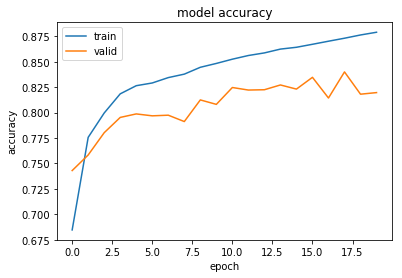

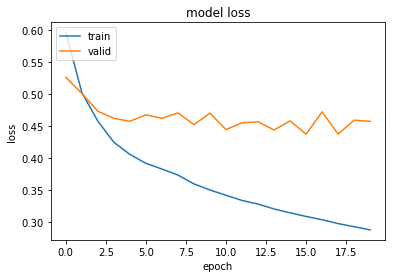

In [28]:
# create model
model = create_model(n_classes, reg_param=REG_PARAM,
                     embedding_dim=EMBEDDING_DIM, embedding_matrix=embedding_matrix,
                     gru_units=GRU_UNITS, context_dim=CONTEXT_DIM, 
                     max_sents=MAX_SENTS, max_sent_length=MAX_SENT_LENGTH, max_num_words=MAX_NB_WORDS)

filepath = './checkpoints'
# Train and validate using 10% of the training set
#model, history = train(x_train, y_train, model, model_path=filepath, 
#                              batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, reg_param=REG_PARAM, show_hist=True)

# Train and validate using a separate validation set
model, history = train_validate(x_train, y_train, x_test, y_test, model, model_path=filepath, 
                              batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, reg_param=REG_PARAM, show_hist=True)

#### Evaluate the model using the test set and report performance results

2018-01-30 11:25:08.915299
2018-01-30 11:25:11.665321
Evaluation time for 3195 sequences = 2.750 secs --> 0.000861 sec/sequence

Accuracy = 0.819718309859155 	 AUC = 0.8149442015260479
Confusion matrix:
[[1615  312]
 [ 264 1004]]
Results saved in ./results/pred_results-sent=5-f1-w2v-strat-epoch=20-lr=0.01.txt


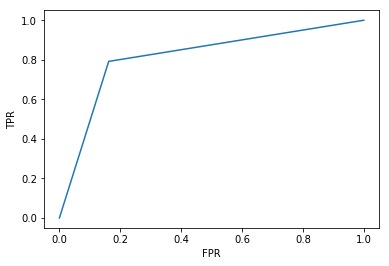

In [29]:
if USE_WORD2VEC:
    ofname = './results/pred_results-sent=%d-f%d-w2v-strat-epoch=%d-lr=%.2f.txt' % (MAX_SENTS, MAX_FIELDS, NUM_EPOCHS, LEARN_RATE)
else:
    ofname = './results/pred_results-sent=%d-f%d-now2v-strat-epoch=%d-lr=%.2f.txt' % (MAX_SENTS, MAX_FIELDS, NUM_EPOCHS, LEARN_RATE)
evaluate(x_test, y_test, model, save=True, outfile=ofname)

### Report and save performance summary statistics per sequence and per overall process
**Note:** Per process performance below takes a majority vote of all sequences in the process in order to determine the predicted process label, i.e., process label = class label with more sequences predicted.<br><br>
This is a rudimentary heuristic for demonstration purposes only. Per sequence labels are more critical for the application of process analysis. A runtime heuristic is needed in order to decide when to terminate a suspicious process.

In [30]:
import pandas as pd
from pandas_confusion import ConfusionMatrix

# Get performance per process
df  = pd.read_csv(ofname, sep='\t', header=0, encoding='utf-8')
df1 = pd.pivot_table(df, values='proc_sid', index=['test_pid', 'y_true'], columns='y_pred', aggfunc='count', fill_value=0)
df1['total'] = df1[0] + df1[1]
df1['%_0'] = df1[0] * 100 / df1['total']
df1['%_1'] = df1[1] * 100 / df1['total']
df1['proc_label'] = df1[1] > df1[0]
df1['proc_label'] = df1['proc_label'].astype(np.int)
sfname = ofname.replace('pred_results', 'pred_summary')
df1.to_csv(sfname, sep='\t', index=True, index_label='test_pid\ty_true', encoding='utf-8')

# Get confusion matrix and overall performance metrics
y_true = df['y_true']
y_pred = df['y_pred']
confusion_mtx = ConfusionMatrix(y_true, y_pred)
print('Sequence Confusion Matrix')
print(confusion_mtx)
#confusion_mtx.plot()
plt.show()

ff = open(sfname, 'a')
print('=========================================================================', file=ff)
print('Sequence Confusion Matrix', file=ff)
print(confusion_mtx, file=ff)
print('=========================================================================', file=ff)

cm = confusion_mtx.to_dataframe()
correct=0
print('Sequence Performance metrics', file=ff)
for i in range(cm.shape[0]):
    correct += cm.iloc[i][i]
    prec   = cm.iloc[i][i] * 100.0 / cm.sum(axis=0)[i]
    recall = cm.iloc[i][i] * 100.0 / cm.sum(axis=1)[i]
    print('Class %s: Recall = %.8f Precision = %.8f' % (cm.columns[i], recall, prec))
    print('Class %s: Recall = %.8f Precision = %.8f' % (cm.columns[i], recall, prec), file=ff)
#print('Overall accuracy = %.4f' % float(correct * 100.0 / sum(cm.sum(axis=0))))
#print('Overall accuracy = %.4f' % float(correct * 100.0 / sum(cm.sum(axis=0))), file=ff)
print("Overall Accuracy = {0} \t AUC = {1}".format(accuracy_score(y_true, y_pred), roc_auc_score(y_true, y_pred)))
print("Overall Accuracy = {0} \t AUC = {1}".format(accuracy_score(y_true, y_pred), roc_auc_score(y_true, y_pred)), file=ff)
#print('=========================================================================', file=ff)
print('')

# Get process-level confusion matrix and overall performance metrics
df2 = pd.DataFrame(columns=['y_true', 'y_pred'])
df2['y_true'] = pd.Series(df1.index.get_level_values(1))
df2['y_pred'] = df1['proc_label'].values
y_true = df2['y_true']
y_pred = df2['y_pred']
confusion_mtx = ConfusionMatrix(y_true, y_pred)
print('Process Confusion Matrix')
print(confusion_mtx)
#confusion_mtx.plot()
plt.show()

print('=========================================================================', file=ff)
print('Process Confusion Matrix', file=ff)
print(confusion_mtx, file=ff)
print('=========================================================================', file=ff)

cm = confusion_mtx.to_dataframe()
correct=0
print('Process Performance metrics', file=ff)
for i in range(cm.shape[0]):
    correct += cm.iloc[i][i]
    prec   = cm.iloc[i][i] * 100.0 / cm.sum(axis=0)[i]
    recall = cm.iloc[i][i] * 100.0 / cm.sum(axis=1)[i]
    print('Class %s: Recall = %.8f Precision = %.8f' % (cm.columns[i], recall, prec))
    print('Class %s: Recall = %.8f Precision = %.8f' % (cm.columns[i], recall, prec), file=ff)
#print('Overall accuracy = %.4f' % float(correct * 100.0 / sum(cm.sum(axis=0))))
#print('Overall accuracy = %.4f' % float(correct * 100.0 / sum(cm.sum(axis=0))), file=ff)
print("Overall Accuracy = {0} \t AUC = {1}".format(accuracy_score(y_true, y_pred), roc_auc_score(y_true, y_pred)))
print("Overall Accuracy = {0} \t AUC = {1}".format(accuracy_score(y_true, y_pred), roc_auc_score(y_true, y_pred)), file=ff)
print('=========================================================================', file=ff)

ff.close()

print('\nPer process results and performance summary saved to %s' % sfname)

Sequence Confusion Matrix
Predicted     0     1  __all__
Actual                        
0          1615   312     1927
1           264  1004     1268
__all__    1879  1316     3195
Class 0: Recall = 83.80902958 Precision = 85.94997339
Class 1: Recall = 79.17981073 Precision = 76.29179331
Overall Accuracy = 0.819718309859155 	 AUC = 0.8149442015260479

Process Confusion Matrix
Predicted  0   1  __all__
Actual                   
0          6   0        6
1          0  33       33
__all__    6  33       39
Class 0: Recall = 100.00000000 Precision = 100.00000000
Class 1: Recall = 100.00000000 Precision = 100.00000000
Overall Accuracy = 1.0 	 AUC = 1.0

Per process results and performance summary saved to ./results/pred_summary-sent=5-f1-w2v-strat-epoch=20-lr=0.01.txt
